# Segmentation

If you have Unet, all CV is segmentation now.

## Goals

- train Unet on isbi dataset
- visualize the predictions

# Preparation

Final folder structure with training data:
```bash
catalyst-examples/
    data/
        isbi/
            train-volume.tif
            train-labels.tif
```

In [88]:
import collections
from pathlib import Path
from typing import Callable, List, Tuple
import os
import random

import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread as gif_imread
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import catalyst
from catalyst.data import Augmentor
from catalyst.dl import utils as dl_utils
from catalyst import utils
from catalyst.contrib.models.segmentation import Unet

from catalyst.dl.runner import SupervisedRunner

import albumentations as albu
from albumentations.pytorch import ToTensor

print(f"torch: {torch.__version__}, catalyst: {catalyst.__version__}")

os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # "" - CPU, "0" - 1 GPU, "0,1" - MultiGPU

SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

torch: 1.3.1, catalyst: 19.12.1


In [73]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [74]:
# this variable will be used in `runner.train` and by default we disable FP16 mode
is_fp16_used = True

# Data

In [75]:

tgt_height = 256
data_dir = Path('../data')
train_images = data_dir/'train_images'
test_img = train_images/'mask_fill/test'

train_path = train_images/'mask_fill/train'
train_mask = train_path/'masks'
train_img = train_path/'images'


In [76]:
ALL_IMAGES = sorted(train_img.glob("*.png"))
len(ALL_IMAGES)

4000

In [77]:
ALL_MASKS = sorted(train_mask.glob("*.png"))
len(ALL_MASKS)

4000

In [78]:
def show_examples(name: str, image: np.ndarray, mask: np.ndarray):
    plt.figure(figsize=(10, 14))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {name}")

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title(f"Mask: {name}")

In [79]:
def show(index: int, images: List[Path], masks: List[Path], transforms=None) -> None:
    image_path = images[index]
    name = image_path.name

    image = utils.imread(image_path)
    mask = gif_imread(masks[index])

    if transforms is not None:
        temp = transforms(image=image, mask=mask)
        image = temp["image"]
        mask = temp["mask"]

    show_examples(name, image, mask)

In [80]:
def show_random(images: List[Path], masks: List[Path], transforms=None) -> None:
    length = len(images)
    index = random.randint(0, length - 1)
    show(index, images, masks, transforms)

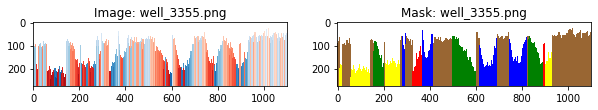

In [81]:
show_random(ALL_IMAGES, ALL_MASKS)

### Dataset

In [82]:
class SegmentationDataset(Dataset):
    def __init__(
        self,
        images: List[Path],
        masks: List[Path] = None,
        transforms=None
    ) -> None:
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> dict:
        image_path = self.images[idx]
        image = utils.imread(image_path)
        
        result = {"image": image}
        
        if self.masks is not None:
            mask = gif_imread(self.masks[idx])
            result["mask"] = mask
        
        if self.transforms is not None:
            result = self.transforms(**result)
        
        result["filename"] = image_path.name

        return result

### Transforms

In [83]:
def pre_transforms(image_size=224):
    return [albu.Resize(image_size, image_size, p=1)]


def hard_transforms():
    result = [
      albu.RandomRotate90(),
      albu.Cutout(),
      albu.RandomBrightnessContrast(
          brightness_limit=0.2, contrast_limit=0.2, p=0.3
      ),
      albu.GridDistortion(p=0.3),
      albu.HueSaturationValue(p=0.3)
    ]

    return result
  

def resize_transforms(image_size=224):
    BORDER_CONSTANT = 0
    pre_size = int(image_size * 1.5)

    random_crop = albu.Compose([
      albu.SmallestMaxSize(pre_size, p=1),
      albu.RandomCrop(
          image_size, image_size, p=1
      )

    ])

    rescale = albu.Compose([albu.Resize(image_size, image_size, p=1)])

    random_crop_big = albu.Compose([
      albu.LongestMaxSize(pre_size, p=1),
      albu.RandomCrop(
          image_size, image_size, p=1
      )

    ])

    # Converts the image to a square of size image_size x image_size
    result = [
      albu.OneOf([
          random_crop,
          rescale,
          random_crop_big
      ], p=1)
    ]

    return result
  
def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [albu.Normalize(), ToTensor()]
  
def compose(transforms_to_compose):
    # combine all augmentations into one single pipeline
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result

In [84]:
train_transforms = compose([
    resize_transforms(), 
    hard_transforms(), 
    post_transforms()
])
valid_transforms = compose([pre_transforms(), post_transforms()])

show_transforms = compose([resize_transforms(), hard_transforms()])

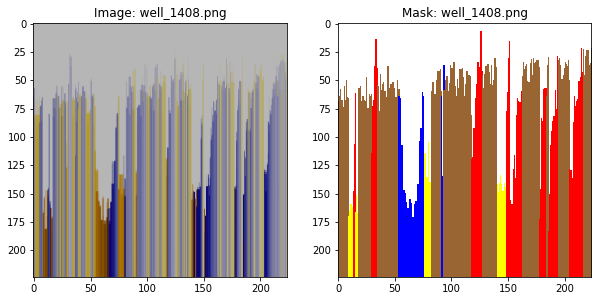

In [85]:
show_random(ALL_IMAGES, ALL_MASKS, transforms=show_transforms)

### Loaders

In [86]:
def get_loaders(
    images: List[Path],
    masks: List[Path],
    random_state: int,
    valid_size: float = 0.2,
    batch_size: int = 32,
    num_workers: int = 4,
    train_transforms_fn = None,
    valid_transforms_fn = None,
) -> dict:

    indices = np.arange(len(images))

    # Let's divide the data set into train and valid parts.
    train_indices, valid_indices = train_test_split(
      indices, test_size=valid_size, random_state=random_state, shuffle=True
    )

    np_images = np.array(images)
    np_masks = np.array(masks)

    # Creates our train dataset
    train_dataset = SegmentationDataset(
      images = np_images[train_indices].tolist(),
      masks = np_masks[train_indices].tolist(),
      transforms = train_transforms_fn
    )

    # Creates our valid dataset
    valid_dataset = SegmentationDataset(
      images = np_images[valid_indices].tolist(),
      masks = np_masks[valid_indices].tolist(),
      transforms = valid_transforms_fn
    )

    # Catalyst uses normal torch.data.DataLoader
    train_loader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      drop_last=True,
    )

    valid_loader = DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=True,
    )

    # And excpect to get an OrderedDict of loaders
    loaders = collections.OrderedDict()
    loaders["train"] = train_loader
    loaders["valid"] = valid_loader

    return loaders

In [87]:
if is_fp16_used:
    batch_size = 64
else:
    batch_size = 32

print(f"batch_size: {batch_size}")

loaders = get_loaders(
    images=ALL_IMAGES,
    masks=ALL_MASKS,
    random_state=SEED,
    train_transforms_fn=train_transforms,
    valid_transforms_fn=valid_transforms,
    batch_size=batch_size
)

batch_size: 64


# Model

In [ ]:


# experiment setup
num_epochs = 50
logdir = "./logs/segmentation_notebook"

# model, criterion, optimizer
model = Unet(num_classes=6, in_channels=1, num_channels=64, num_blocks=4)
criterion = nn.CEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20, 40], gamma=0.3)


# model runner
runner = SupervisedRunner()

# model training
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    logdir=logdir,
    num_epochs=num_epochs,
    verbose=True
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/50 * Epoch (train): 100% 7/7 [00:02<00:00,  2.61it/s, loss=0.397]
1/50 * Epoch (valid): 100% 1/1 [00:00<00:00,  3.32it/s, loss=0.895]
[2019-12-14 22:08:55,901] 
1/50 * Epoch 1 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=571.8035 | _timers/batch_time=0.0336 | _timers/data_time=0.0216 | _timers/model_time=0.0119 | loss=0.4898
1/50 * Epoch 1 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=29.5010 | _timers/batch_time=0.1356 | _timers/data_time=0.1263 | _timers/model_time=0.0090 | loss=0.8954
2/50 * Epoch (train): 100% 7/7 [00:02<00:00,  2.61it/s, loss=0.327]
2/50 * Epoch (valid): 100% 1/1 [00:00<00:00,  3.09it/s, loss=0.576]
[2019-12-14 22:09:07,649] 
2/50 * Epoch 2 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=536.5173 | _timers/batch_time=0.0312 | _timers/data_time=0.0236 | _timers/model_time=0.0075 | loss=0.3571
2/50 * Epoch 2 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=25.6064 | _timers/batch_time=0.1562 | _ti

# Inference

In [ ]:
runner_out = runner.predict_loader(
    model, loaders["valid"], resume=f"{logdir}/checkpoints/best.pth"
)

# Predictions visualization

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [ ]:
sigmoid = lambda x: 1/(1 + np.exp(-x))

for i, (input, output) in enumerate(zip(valid_data, runner_out)):
    image, mask = input
    
    threshold = 0.5
    
    plt.figure(figsize=(10,8))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image, 'gray')
    
    plt.subplot(1, 3, 2)
    output = sigmoid(output[0].copy())
    output = (output > threshold).astype(np.uint8)
    plt.imshow(output, 'gray')
    
    plt.subplot(1, 3, 3)
    plt.imshow(mask, 'gray')
    
    plt.show()